In [2]:
from fredapi import Fred
fred = Fred(api_key='91d55a1617750e1cc9dadb64d1e4c679')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (11,6)

import pandas as pd
import numpy as np
import pandas_datareader as pdr
import datetime
import statistics
import quantecon as qe
from quantecon import MarkovChain

# Assignment 3: Working with Markov Chains  
Kiran Ferrini

1. Import the Weekly Economic Index from FRED. Plot it and make it a dataframe.

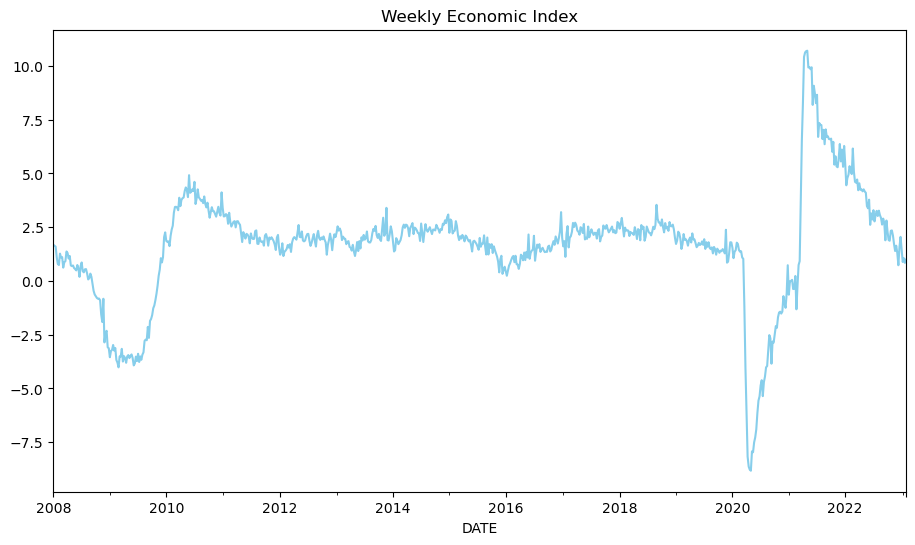

In [3]:
start = datetime.datetime(2008, 1, 5)
end = datetime.datetime(2023, 1, 28)

df_WEI = pdr.DataReader('WEI', 'fred', start, end)

x = df_WEI['WEI']

x.plot(color = 'skyblue', title='Weekly Economic Index')
plt.show()

2. Use the Augmented Dickey Fuller Test to see if the index is stationary. Plot the partial autocorrelations out to 25 lags.

P-value for ADF Test:  0.011497628684725992


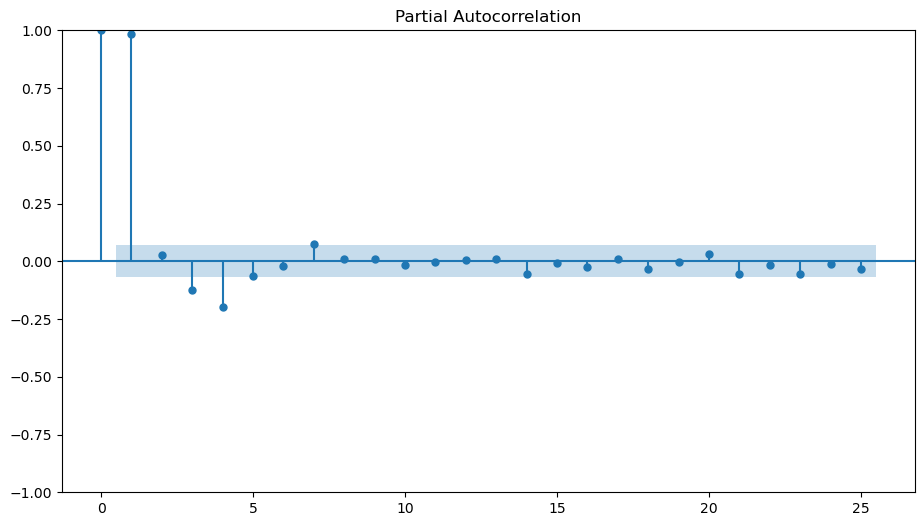

In [4]:
ADF = adfuller(x, autolag = 'AIC')
print("P-value for ADF Test: ", ADF[1])

pacf = plot_pacf(x, method = 'ywm', lags = 25)

3. Plot a histogram of the data, and return the counts, bins and patches. 

Counts:  [  9.   5.  43.  31.  73. 494.  84.  29.  10.   9.]
Bins:  [-8.83  -6.876 -4.922 -2.968 -1.014  0.94   2.894  4.848  6.802  8.756
 10.71 ]
Patches:  <BarContainer object of 10 artists>


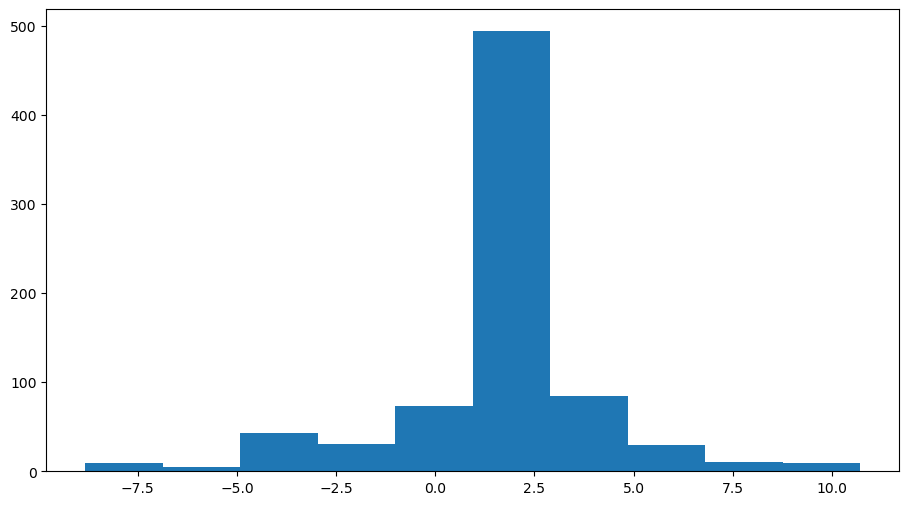

In [5]:
n, bins, patches = plt.hist(x)
print('Counts: ', n)
print('Bins: ', bins)
print('Patches: ', patches)

4. Classify the data into states, corresponding to the intervals between the bins. 

In [45]:
States = range(0,10)
def classify(x,bins,states):
    """
    x is the data
    bins gives the break points
    states are the names of the states
    """
    n = len(bins) # the number of edges of the bins is one more than the number of states
    conditions = []
    for i in range(n-1): # define an array of logical conditions
        conditions.append((x <= bins[i+1]) & (x >= bins[i]))
    return(np.select(conditions, states))

df_WEI['States'] = classify(x, bins, States)
df_WEI['States'].describe()

count    787.000000
mean       4.846252
std        1.288230
min        0.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        9.000000
Name: States, dtype: float64

5. Group the data by the mean within each state.  This has the interpretation as the mean growth rate in that state.

In [32]:
df_WEI.groupby(['States'])['WEI'].mean()

States
0    -8.002222
1    -5.702000
2    -3.646744
3    -1.992258
4     0.284521
5     1.969696
6     3.620476
7     5.898276
8     7.808000
9    10.133333
Name: WEI, dtype: float64

6. Estimate the Markov matrix.

In [51]:
estmm = qe.markov.estimate.estimate_mc(df_WEI['States'])
estmm.P
pd.DataFrame(estmm.P).style.background_gradient(axis=None, cmap='GnBu')

,0,1,2,3,4,5,6,7,8,9
0,0.888889,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.200000,0.400000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.046512,0.883721,0.069767,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.096774,0.741935,0.161290,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.054795,0.767123,0.164384,0.013699,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.002028,0.024341,0.949290,0.024341,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.154762,0.809524,0.035714,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103448,0.758621,0.137931,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.400000,0.200000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.777778


7. Check if the chain is aperiodic and irreducible.  Also, find its communication classes.

In [34]:
estmm.is_aperiodic

True

In [10]:
estmm.is_irreducible

True

In [11]:
estmm.communication_classes

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])]

> The chain is both aperiodic and irreducible. Also all 10 classes can communicate with eachother. This means that it is possible to get to any given state from any other (cannot get "stuck"). 

8. Find the ergodic distribution of states.  Is it unique?

In [35]:
estmm.stationary_distributions

array([[0.01145038, 0.00636132, 0.05470738, 0.0394402 , 0.09287532,
        0.62722646, 0.10687023, 0.03689567, 0.01272265, 0.01145038]])

> This Markov matrix MUST have a unique stationary distribution because it is both aperiodic and irreducible.

9. Plot a simulation of the process for two years, starting from its current value.

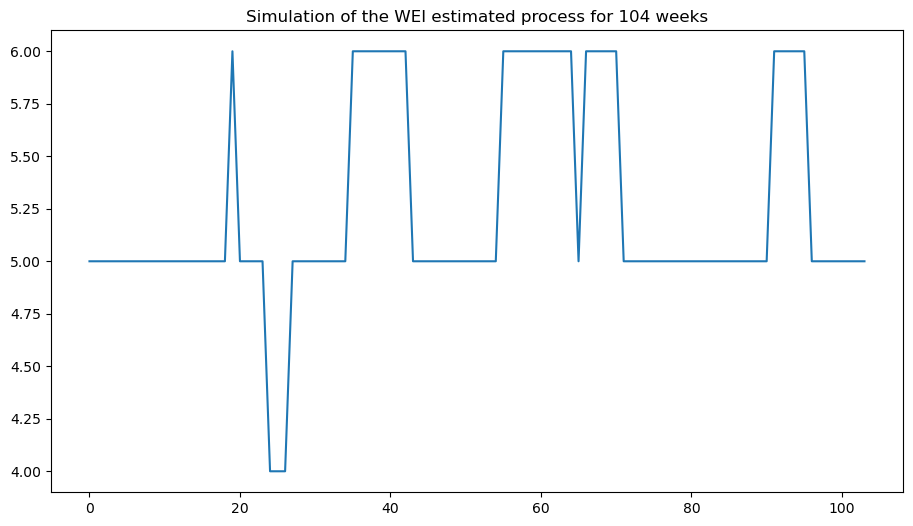

In [38]:
plt.plot(estmm.simulate(ts_length=104, init=df_WEI['States'][-1])) 
plt.title("Simulation of the WEI estimated process for 104 weeks")
plt.show()

10.  Calculate the mean hitting time between occurrences of the worst state.

In [41]:
from numpy.linalg import inv 

current = df_WEI['States'][-1]
A = estmm.P[1:, 1:]
print('The mean time for the return to the worst state is', 
      np.around((np.linalg.inv(np.identity(9)-A)@np.ones(9))[current-1],0),'weeks')

The mean time for the return to the worst state is 1582.0 weeks


11.  What is the probability that we will see another Covid state in the next two years?

In [43]:
P = estmm.P.copy()
p = estmm.P[current,:].copy()

for t in range(104):
    p[0] = 0.0
    p = p@P
    prob = np.sum(p[1:])
    
print('The probability of seeing another "COVID State" is') 
np.around(1-prob,5)

The probability that we will enter another Covid/Worst State is:


0.04906

12. Finally, simulate the Markov chain for a sample size as large as the data set itself. Repeat part 2 on the simulated data. Does the Markov model seem to simulate the data well?

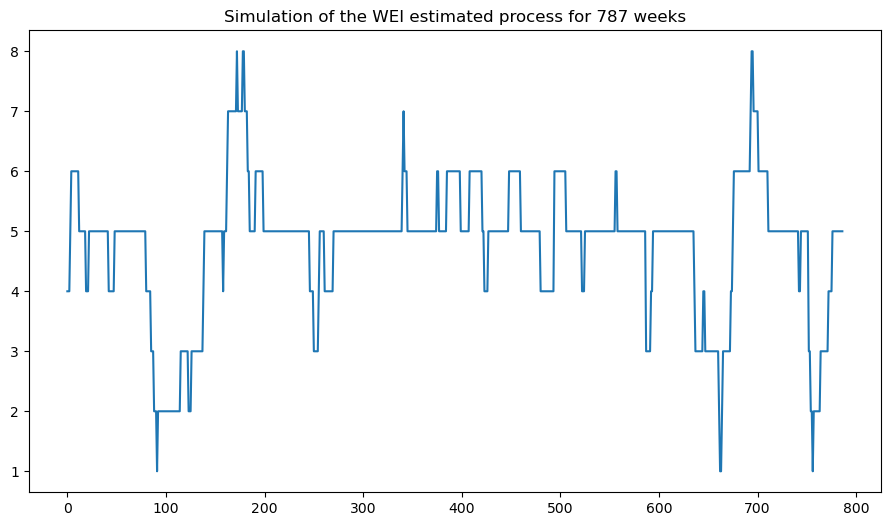

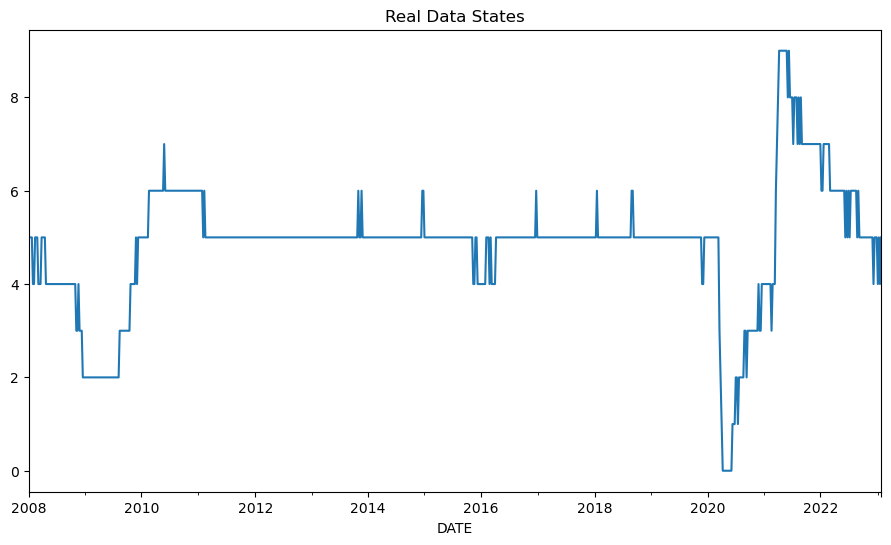

P-value for ADF Test:  9.521860599109964e-05


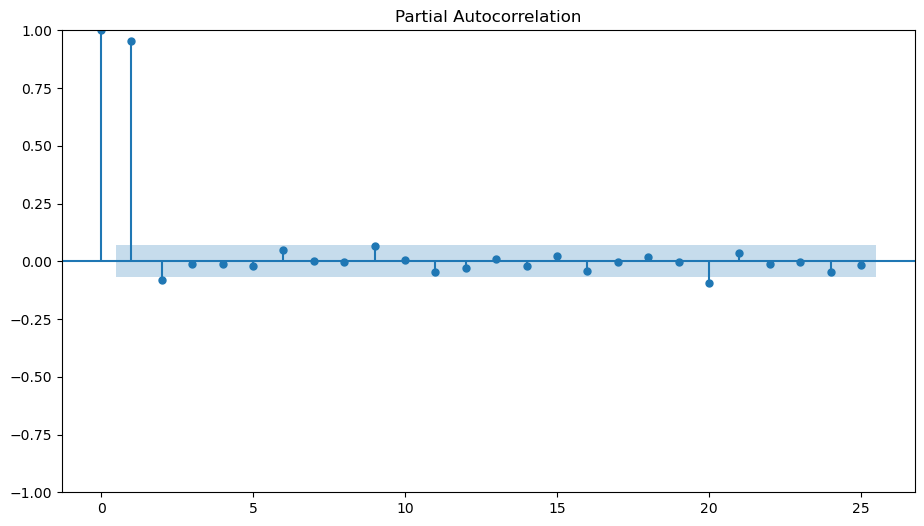

In [48]:
sim = estmm.simulate(ts_length=787, init=4)
plt.plot(sim) 
plt.title("Simulation of the WEI estimated process for 787 weeks")
plt.show()

df_WEI['States'].plot()
plt.title("Real Data States")
plt.show()

ADF2 = adfuller(sim, autolag = 'AIC')
print("P-value for ADF Test: ", ADF2[1])
pacf2 = plot_pacf(sim, method = 'ywm', lags = 25)

The simulation seems to simulate the data in an okay way. The 2008 and 2020 recessions are often captured at least. Like the real data the ADF test p-value is sufficiently small to reject the null hypothesis of a unit root, and the partial autocorrelation becomes insignificant after 2-3 lags.